In [62]:
import numpy as np
import scipy
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import pickle
import sys

In [63]:
def ldaLearn(X, y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix

    # IMPLEMENT THIS METHOD
    d = X.shape[1]
    y_size = y.size
    y_class = y.reshape(y_size)
    y_uclass = np.unique(y_class)
    y_uclass_size = y_uclass.size
    means = np.zeros((d,y_uclass_size))
    for i in range(y_uclass_size):
        means[:,i] = np.mean(X[y_class == y_uclass[i]],axis=0)
    #print("Means ", means)
    covmat = np.cov(X,rowvar=0)
    #print("CovMat ", covmat)
    return means, covmat

In [64]:
def qdaLearn(X, y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes

    # IMPLEMENT THIS METHOD
    d = X.shape[1]
    y_size = y.size
    y_class = y.reshape(y_size)
    y_uclass = np.unique(y_class)
    y_uclass_size = y_uclass.size
    means = np.zeros((d,y_uclass_size))
    covmats = [np.zeros((d,d))]*y_uclass_size

    for i in range(y_uclass_size):
        means[:,i] = np.mean(X[y_class == y_uclass[i]],axis=0)
        covmats[i] = np.cov(X[y_class == y_uclass[i]],rowvar=0)

    return means, covmats

In [65]:
def ldaTest(means, covmat, Xtest, ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    y_prob = np.zeros((Xtest.shape[0],means.shape[1]))
    n_class = means.shape[1]
    for i in range(n_class):
        invcovmat = np.linalg.inv(covmat)
        t1 = Xtest - means[:,i]
        #print("T1 ",t1)
        #print("invcovmat ",invcovmat)
        t2 = np.dot(t1,invcovmat)
        t3 = np.sum(t2 * t1,1)
        t4 = np.exp(-0.5*t3)
        y_prob[:,i] = t4

    #print(y_prob)
    ypred = np.argmax(y_prob,1) + 1
    print("ypred ", ypred)
    ytest = ytest.reshape(ytest.size)
    print("ytest ", ytest)
    acc = 100 * np.mean(ytest == ypred)
    return acc, ypred

In [66]:
def qdaTest(means, covmats, Xtest, ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
#     print("N : ", Xtest.shape[0])
#     print("Class : ", means.shape[1])
    y_prob = np.zeros((Xtest.shape[0],means.shape[1]))
    n_class = means.shape[1]

    for i in range(n_class):
        invcovmat = np.linalg.inv(covmats[i])
        t1 = Xtest - means[:,i]
        #print("T1 ",t1)
        #print("invcovmat ",invcovmat)
        t2 = np.dot(t1,invcovmat)
        t3 = np.sum(t2 * t1,1)
        t4 = np.exp(-0.5*t3)

        y_prob[:,i] = t4

    #print(y_prob)
    ypred = np.argmax(y_prob,1) + 1
    print("ypred ", ypred)

    ytest = ytest.reshape(ytest.size)
    print("ytest ", ytest)
    acc = 100 * np.mean(ytest == ypred)

    return acc, ypred

In [67]:
def learnOLERegression(X, y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1
    
    # IMPLEMENT THIS METHOD
    
    w = np.dot(inv(np.dot(np.transpose(X),X)), np.dot(np.transpose(X), y))
    return w

In [68]:
def learnRidgeRegression(X, y, lambd):
    # Inputs:
    # X = N x d
    # y = N x 1
    # lambd = ridge parameter (scalar)
    # Output:
    # w = d x 1

    # IMPLEMENT THIS METHOD
    Xt_X = np.dot(np.transpose(X), X)
    LI = lambd*np.eye(Xt_X.shape[0])
    w_l = np.dot(inv(Xt_X+LI), np.dot(np.transpose(X), y))
    return w_l

In [69]:
def testOLERegression(w, Xtest, ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse

    # IMPLEMENT THIS METHOD
    y_est = np.dot(Xtest,w)
    error = y_est - ytest
    #https://mathinsight.org/dot_product_matrix_notation
    #implementing the formula - 1/N (ytest-XtestT w)T (ytest-XtestT w)
    mse = np.dot(np.transpose(error),error)/(error.shape[0])
    mle = mse
    return mse

In [70]:
def regressionObjVal(w, X, y, lambd):
    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda

    # IMPLEMENT THIS METHOD
    # implementing the formula
    # 0.5 ((y - Xw)T .(y - Xw) + lambda * wT .W)
    d = X.shape[1]
    w_mat = np.reshape(w,(d,1))
    inter = y - np.dot(X_i,w_mat)
    
    error = 0.5*(np.dot(inter.transpose(),inter) + lambd*np.dot(w_mat.transpose(),w_mat))
    
    # diff the same 
    # -0.5 * xT (y-Xw) + lambda * w
    error_grad = -(np.dot(X_i.transpose(),inter)) + lambd*w_mat
    error_grad = np.squeeze(np.array(error_grad))
    
    return error,error_grad

In [71]:
def mapNonLinear(x, p):
    # Inputs:
    # x - a single column vector (N x 1)
    # p - integer (>= 0)
    # Outputs:
    # Xp - (N x (p+1))

    # IMPLEMENT THIS METHOD
    Xp = np.ones((x.shape[0],p+1))
    for i in range(1,p+1):
        Xp[:,i] = x**i
    return Xp

In [72]:
#Main script

# Problem 1
# load the sample data
if sys.version_info.major == 2:
    X, y, Xtest, ytest = pickle.load(open('./sample.pickle', 'rb'))
else:
    X, y, Xtest, ytest = pickle.load(open('./sample.pickle', 'rb'), encoding='latin1')

# LDA
means, covmat = ldaLearn(X, y)
ldaacc, ldares = ldaTest(means, covmat, Xtest, ytest)
print('LDA Accuracy = ' + str(ldaacc))
# QDA
means, covmats = qdaLearn(X, y)
qdaacc, qdares = qdaTest(means, covmats, Xtest, ytest)
print('QDA Accuracy = ' + str(qdaacc))


ypred  [2 2 3 4 3 2 5 4 4 4 3 5 2 2 4 1 1 1 5 3 5 1 4 3 5 1 1 2 5 2 5 5 3 5 3 4 2
 3 1 2 4 5 1 1 4 4 5 3 5 5 5 4 1 5 4 4 1 3 3 1 1 4 5 3 5 4 2 3 3 3 5 2 2 1
 4 4 4 1 1 4 1 3 4 5 3 4 3 3 3 2 5 1 5 2 5 4 4 5 5 1]
ytest  [2. 2. 3. 4. 3. 5. 5. 4. 4. 4. 3. 5. 2. 2. 4. 1. 1. 1. 5. 3. 5. 1. 4. 3.
 5. 1. 1. 2. 5. 2. 5. 5. 3. 5. 3. 4. 2. 3. 1. 2. 4. 5. 1. 1. 4. 4. 5. 3.
 5. 5. 5. 4. 1. 5. 4. 4. 1. 3. 3. 1. 1. 4. 5. 3. 5. 4. 4. 3. 3. 3. 5. 2.
 2. 1. 4. 4. 4. 1. 1. 4. 1. 3. 4. 5. 3. 4. 3. 3. 3. 3. 5. 1. 5. 2. 5. 4.
 4. 5. 5. 1.]
LDA Accuracy = 97.0
ypred  [2 2 3 4 3 2 5 4 4 4 3 5 2 2 4 1 1 1 5 3 5 1 4 3 5 1 1 2 5 2 5 5 3 5 3 4 2
 3 1 2 4 5 2 1 4 4 5 3 5 5 5 4 1 5 4 4 2 3 3 1 1 4 5 3 5 4 2 3 3 3 5 2 2 1
 4 4 4 1 1 4 1 3 4 5 2 4 3 3 3 2 5 1 5 2 5 4 4 5 5 1]
ytest  [2. 2. 3. 4. 3. 5. 5. 4. 4. 4. 3. 5. 2. 2. 4. 1. 1. 1. 5. 3. 5. 1. 4. 3.
 5. 1. 1. 2. 5. 2. 5. 5. 3. 5. 3. 4. 2. 3. 1. 2. 4. 5. 1. 1. 4. 4. 5. 3.
 5. 5. 5. 4. 1. 5. 4. 4. 1. 3. 3. 1. 1. 4. 5. 3. 5. 4. 4. 3. 3. 3. 5. 2.
 2. 1. 4. 4. 4. 1. 

ypred  [1 1 1 ... 5 5 5]
ytest  [0. 0. 0. ... 0. 0. 0.]
ypred  [1 1 1 ... 5 5 5]
ytest  [0. 0. 0. ... 0. 0. 0.]


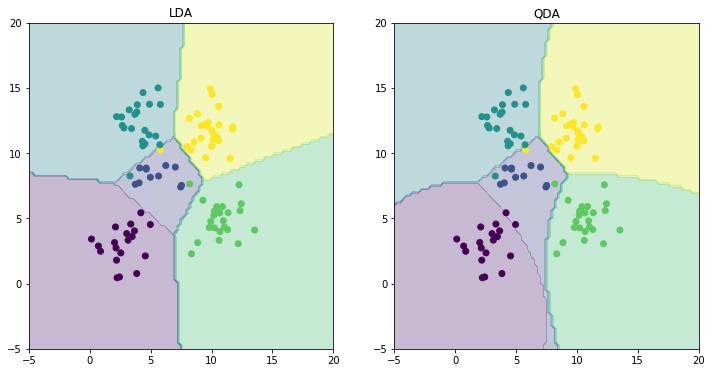

In [73]:
# plotting boundaries
x1 = np.linspace(-5, 20, 100)
x2 = np.linspace(-5, 20, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xx = np.zeros((x1.shape[0] * x2.shape[0], 2))
xx[:, 0] = xx1.ravel()
xx[:, 1] = xx2.ravel()

fig = plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)

zacc, zldares = ldaTest(means, covmat, xx, np.zeros((xx.shape[0], 1)))
plt.contourf(x1, x2, zldares.reshape((x1.shape[0], x2.shape[0])), alpha=0.3)
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest.ravel())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc, zqdares = qdaTest(means, covmats, xx, np.zeros((xx.shape[0], 1)))
plt.contourf(x1, x2, zqdares.reshape((x1.shape[0], x2.shape[0])), alpha=0.3)
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest.ravel())
plt.title('QDA')

plt.show()

In [74]:
# ADD TRAINING DATA 

# Problem 2
if sys.version_info.major == 2:
    X, y, Xtest, ytest = pickle.load(open('./diabetes.pickle', 'rb'))
else:
    X, y, Xtest, ytest = pickle.load(open('./diabetes.pickle', 'rb'), encoding='latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0], 1)), Xtest), axis=1)

print('Training Data')
w = learnOLERegression(X, y)
mle = testOLERegression(w, X, y)

w_i = learnOLERegression(X_i, y)
mle_i = testOLERegression(w_i, X_i, y)

print('MSE without intercept ' + str(mle))
print('MSE with intercept ' + str(mle_i))

print('Test Data')
wtest = learnOLERegression(X, y)
mle_test = testOLERegression(wtest, Xtest, ytest)

wtest_i = learnOLERegression(X_i, y)
mle_test_i = testOLERegression(wtest_i, Xtest_i, ytest)

print('MSE without intercept' + str(mle_test))
print('MSE with intercept' + str(mle_test_i))
print('\n\nWeights for test data with intercept', wtest_i)

Training Data
MSE without intercept [[19099.44684457]]
MSE with intercept [[2187.16029493]]
Test Data
MSE without intercept[[106775.36155223]]
MSE with intercept[[3707.84018148]]


Weights for test data with intercept [[ 1.48154876e+02]
 [ 1.27485203e+00]
 [-2.93383522e+02]
 [ 4.14725448e+02]
 [ 2.72089134e+02]
 [-8.66394571e+04]
 [ 7.59144680e+04]
 [ 3.23416228e+04]
 [ 2.21101214e+02]
 [ 2.92995512e+04]
 [ 1.25230360e+02]
 [ 9.44110833e+01]
 [-9.38628632e+01]
 [-3.37282800e+01]
 [ 3.35319771e+03]
 [-6.21096308e+02]
 [ 7.91736533e+02]
 [ 1.76776039e+03]
 [ 4.19167406e+03]
 [ 1.19438121e+02]
 [ 7.66103400e+01]
 [-1.52001293e+01]
 [ 8.22424594e+01]
 [-1.45666208e+03]
 [ 8.27386703e+02]
 [ 8.69290952e+02]
 [ 5.86234495e+02]
 [ 4.27026727e+02]
 [ 9.02467690e+01]
 [-1.78876224e+01]
 [ 1.41696774e+02]
 [ 5.82819384e+02]
 [-2.34037511e+02]
 [-2.56071452e+02]
 [-3.85177401e+02]
 [-3.34176736e+01]
 [-1.07350066e+01]
 [ 2.57107189e+02]
 [ 5.99554592e+01]
 [ 3.83728042e+02]
 [-4.04158390e+02]
 [-

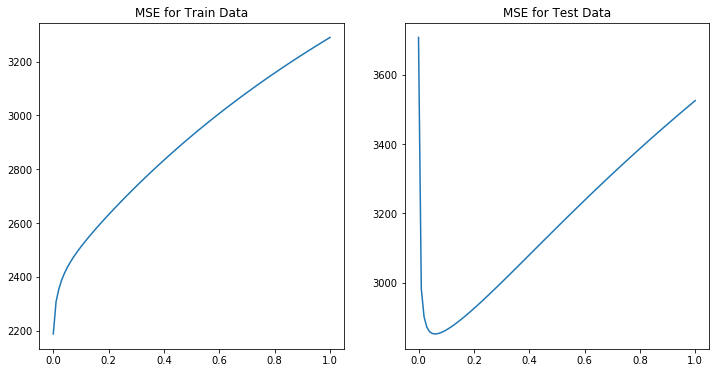

In [75]:
#ADD OPTIMAL LAMBDA

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k, 1))
mses3 = np.zeros((k, 1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i, y, lambd)
    mses3_train[i] = testOLERegression(w_l, X_i, y)
    mses3[i] = testOLERegression(w_l, Xtest_i, ytest)
#     if lambd == 0.05:
#         print("Weights in Ridge Regression #3: ", w_l)
#     print ("lambda  train             test")
#     print(lambd, mses3_train[i], mses3[i])
    i = i + 1

# hardcoded by looking into the data
opt_lambda = 0.05
opt_w = learnRidgeRegression(X_i,y,opt_lambda)
train_error = testOLERegression(opt_w,X_i,y)
test_error = testOLERegression(opt_w,Xtest_i,ytest)
# print ("\n\n Using optimum lambda 0.05")
# print (" weights : ",opt_w)
# print (" Train Error", train_error," Test Error ",test_error)

fig = plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.plot(lambdas, mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas, mses3)
plt.title('MSE for Test Data')

plt.show()

lambda      train mse    test mse
0.0   [2433.66541219]   [2900.54595594]
0.01   [2396.70869149]   [2864.51103823]
0.02   [2431.41923549]   [2841.57743002]
0.03   [2457.27641031]   [2849.18881984]
0.04   [2470.33861771]   [2860.49378955]
0.05   [2467.3097612]   [2843.08348391]
0.06   [2462.04625459]   [2879.73843814]
0.07   [2482.84388994]   [2851.19838906]
0.08   [2509.37968122]   [2868.06415314]
0.09   [2520.81625511]   [2860.188624]
0.1   [2531.70970126]   [2864.54058349]
0.11   [2542.31631364]   [2873.25976178]
0.12   [2551.43834489]   [2883.00579439]
0.13   [2563.46639061]   [2880.21312412]
0.14   [2573.58088061]   [2891.40322341]
0.15   [2580.56994082]   [2894.87327601]


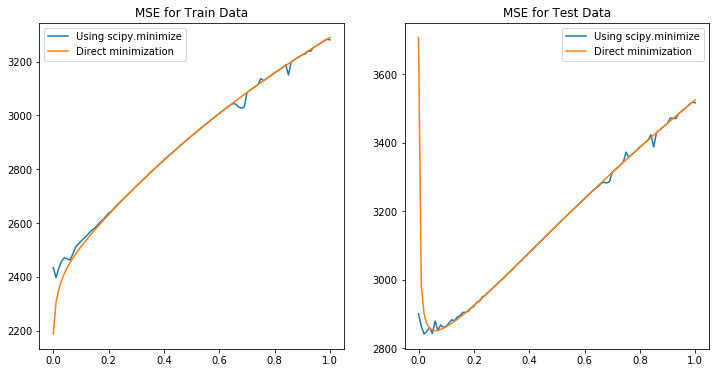

In [76]:
#Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k, 1))
mses4 = np.zeros((k, 1))
opts = {'maxiter': 20}  # Preferred value.
w_init = np.ones((X_i.shape[1], 1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args, method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l, [len(w_l), 1])
    mses4_train[i] = testOLERegression(w_l, X_i, y)
    mses4[i] = testOLERegression(w_l, Xtest_i, ytest)
    i = i + 1

#find minimum lambda
index = 0;
print ("lambda      train mse    test mse")
while (index < len(w_l)):
    print (lambdas[index]," ",mses4_train[index], " ", mses4[index])
    index += 1;
    if (index > 15):
       break;
    
fig = plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.plot(lambdas, mses4_train)
plt.plot(lambdas, mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize', 'Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas, mses4)
plt.plot(lambdas, mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize', 'Direct minimization'])
plt.show()

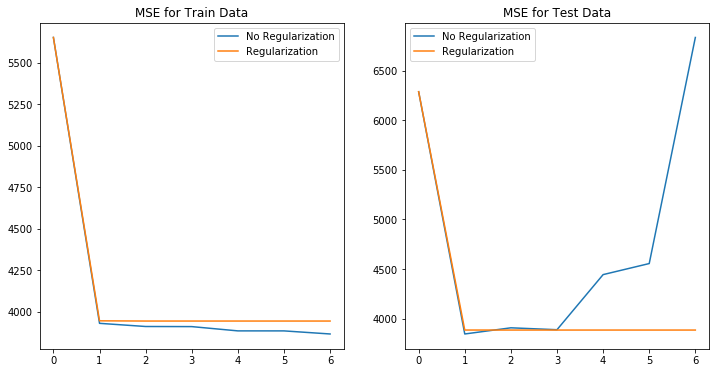

p    Train                 Test                 Train(0.05)              Test(0.05)
0    5650.710538897617     6286.404791680897    5650.711489069524    6286.802264172339
1    3930.915407315901     3845.0347301734146    3945.9948342861508    3884.6956229031584
2    3911.839671204956     3907.1280991079366    3944.6776809012486    3884.5456790265966
3    3911.18866493145     3887.975538236015    3944.673052639404    3884.546641924834
4    3885.4730681122714     4443.327891813341    3944.6728330323867    3884.546635661096
5    3885.4071573970805     4554.830377434614    3944.672831291066    3884.5466368965554
6    3866.8834494460493     6833.459148719649    3944.672831252616    3884.546636929001


In [77]:
# Problem 5
pmax = 7
lambda_opt = 0.05  # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax, 2))
mses5 = np.zeros((pmax, 2))
for p in range(pmax):
    Xd = mapNonLinear(X[:, 2], p)
    Xdtest = mapNonLinear(Xtest[:, 2], p)
    w_d1 = learnRidgeRegression(Xd, y, 0)
    mses5_train[p, 0] = testOLERegression(w_d1, Xd, y)
    mses5[p, 0] = testOLERegression(w_d1, Xdtest, ytest)
    w_d2 = learnRidgeRegression(Xd, y, lambda_opt)
    mses5_train[p, 1] = testOLERegression(w_d2, Xd, y)
    mses5[p, 1] = testOLERegression(w_d2, Xdtest, ytest)

fig = plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax), mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization', 'Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax), mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization', 'Regularization'))
plt.show()

#analysis

index = 0; 
print ("p    Train                 Test                 Train(0.05)              Test(0.05)")
while (index < len(mses5_train[:,0])):
    print (index, "  ",mses5_train[index,0],"   ",mses5[index,0],"  ",mses5_train[index,1],"  ",mses5[index,1])
    index += 1